# Binary classification of commutative diagrams
## 1. Data pipeline

In [1]:
#import torch
import os
import shutil
import random
import math
from copy import deepcopy

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models
import tensorflow_addons as tfa # Needed for Yogi optimizer
tfa.register_all(custom_kernels=False) # Registers TFA objects in TF dictionaries
import matplotlib.pyplot as plt
%matplotlib inline

### 1.1 Expand working directory with folders for training images

In [2]:
##
unsortedSamplesDirName = 'diagramSamplesMarch25'
##

cwd = os.getcwd()

unsortedSamplesDir = os.path.join(cwd, unsortedSamplesDirName)
assert('positive' in os.listdir(unsortedSamplesDir) and 'negative' in os.listdir(unsortedSamplesDir))
unsortedPositiveSamplesDir = os.path.join(unsortedSamplesDir, 'positive')
unsortedNegativeSamplesDir = os.path.join(unsortedSamplesDir, 'negative')

sortedSamplesDir = os.path.join(cwd, 'sortedSamples')
os.makedirs(sortedSamplesDir, exist_ok=True)

trainDir = os.path.join(sortedSamplesDir, 'train')
testDir = os.path.join(sortedSamplesDir, 'test')
valDir = os.path.join(sortedSamplesDir, 'val')
os.makedirs(trainDir, exist_ok=True)
os.makedirs(testDir, exist_ok=True)
os.makedirs(valDir, exist_ok=True)

trainPositiveDir = os.path.join(trainDir, 'positive')
trainNegativeDir = os.path.join(trainDir, 'negative')
testPositiveDir = os.path.join(testDir, 'positive')
testNegativeDir = os.path.join(testDir, 'negative')
valPositiveDir = os.path.join(valDir, 'positive')
valNegativeDir = os.path.join(valDir, 'negative')
os.makedirs(trainPositiveDir, exist_ok=True)
os.makedirs(trainNegativeDir, exist_ok=True)
os.makedirs(testPositiveDir, exist_ok=True)
os.makedirs(testNegativeDir, exist_ok=True)
os.makedirs(valPositiveDir, exist_ok=True)
os.makedirs(valNegativeDir, exist_ok=True)

### 1.2 Copy images into train, test and validation folders
The code currently randomly truncates the greater partition between positive and negative to achieve parity.

In [3]:
##
trainRatio = 0.6
testRatio = 0.2
valRatio = 0.2
assert(trainRatio + testRatio + valRatio == 1.)

positiveRatio = 0.5 # Desired ratio of positive samples in the sorted data

performCopy = False
##

if performCopy:
    positiveSamplesFilenameList = os.listdir(unsortedPositiveSamplesDir)
    negativeSamplesFilenameList = os.listdir(unsortedNegativeSamplesDir)
    random.shuffle(positiveSamplesFilenameList)
    random.shuffle(negativeSamplesFilenameList)
    numPositiveSamples = len(positiveSamplesFilenameList)
    numNegativeSamples = len(negativeSamplesFilenameList)

    if numPositiveSamples > numNegativeSamples:
        positiveSamplesFilenameList = positiveSamplesFilenameList[:numNegativeSamples]
        numPositiveSamples = len(positiveSamplesFilenameList)
    elif numNegativeSamples > numPositiveSamples:
        negativeSamplesFilenameList = negativeSamplesFilenameList[:numPositiveSamples]
        numNegativeSamples = len(negativeSamplesFilenameList)
    assert(numPositiveSamples == numNegativeSamples)

    numSamples = numPositiveSamples + numNegativeSamples

    numTrainSamples = math.floor(numSamples*trainRatio)
    numTestSamples = math.floor(numSamples*testRatio)
    numValSamples = math.floor(numSamples*valRatio)


    unsortedSamplesInfo = {'posDir':unsortedPositiveSamplesDir, 'negDir':unsortedNegativeSamplesDir, 'posFilenameList':positiveSamplesFilenameList,
                           'negFilenameList':negativeSamplesFilenameList}

    trainCopyInfo = {'num':numTrainSamples, 'posDir':trainPositiveDir, 'negDir':trainNegativeDir}
    testCopyInfo = {'num':numTestSamples, 'posDir':testPositiveDir, 'negDir':testNegativeDir}
    valCopyInfo = {'num':numValSamples, 'posDir':valPositiveDir, 'negDir':valNegativeDir}

    def copyImagesInPartition(unsortedSamplesInfo:dict, partitionCopyInfo:dict):
        for _ in range(math.floor(partitionCopyInfo['num']*positiveRatio)):
            copyImage(unsortedSamplesInfo['posFilenameList'], unsortedSamplesInfo['posDir'], partitionCopyInfo['posDir'])
        for _ in range(math.floor(partitionCopyInfo['num']*(1. - positiveRatio))):
            copyImage(unsortedSamplesInfo['negFilenameList'], unsortedSamplesInfo['negDir'], partitionCopyInfo['negDir'])

    def copyImage(sampleFilenameList, srcDir, dstDir):
        filename = sampleFilenameList.pop()
        src = os.path.join(srcDir, filename)
        dst = os.path.join(dstDir, filename)
        try:
            shutil.copyfile(src, dst)
        except PermissionError: # Ignores straggler files such as notebook checkpoints
            pass

    sampleDirectorySizes = [len(directory) for directory in [
        os.listdir(trainPositiveDir), os.listdir(trainNegativeDir), os.listdir(testPositiveDir), os.listdir(testNegativeDir),
        os.listdir(testPositiveDir), os.listdir(testNegativeDir)]]

    if all(size == 0 for size in sampleDirectorySizes):
        copyImagesInPartition(unsortedSamplesInfo, trainCopyInfo)
        copyImagesInPartition(unsortedSamplesInfo, testCopyInfo)
        copyImagesInPartition(unsortedSamplesInfo, valCopyInfo)
    else:
        raise Exception("Sorted image directories are not empty.")

[*Optional*]: Test whether a sample handful of the images were copied to the correct folders

In [4]:
##
runImageCopyTest = False

comparisonSampleSize = 50
imageFiletype = 'png'
##

if runImageCopyTest and performCopy:
    # These must be redefined here since they were popped
    positiveSamplesFilenameList = os.listdir(unsortedPositiveSamplesDir)
    negativeSamplesFilenameList = os.listdir(unsortedNegativeSamplesDir)

    sortedTrainPositiveFilenameList = os.listdir(trainPositiveDir)
    sortedTrainNegativeFilenameList = os.listdir(trainNegativeDir)
    sortedTestPositiveFilenameList = os.listdir(testPositiveDir)
    sortedTestNegativeFilenameList = os.listdir(testNegativeDir)
    sortedValPositiveFilenameList = os.listdir(valPositiveDir)
    sortedValNegativeFilenameList = os.listdir(valNegativeDir)
    random.shuffle(sortedTrainPositiveFilenameList)
    random.shuffle(sortedTrainNegativeFilenameList)
    random.shuffle(sortedTestPositiveFilenameList)
    random.shuffle(sortedTestNegativeFilenameList)
    random.shuffle(sortedValPositiveFilenameList)
    random.shuffle(sortedValNegativeFilenameList)

    allPositiveFilenameLists = [sortedTrainPositiveFilenameList, sortedTestPositiveFilenameList, sortedValPositiveFilenameList]
    allNegativeFilenameLists = [sortedTrainNegativeFilenameList, sortedTestNegativeFilenameList, sortedValNegativeFilenameList]

    def matchesImageFiletype(sampleFilename : str, imageFiletype : str): # Needed to ignore straggler files such as notebook checkpoints
        return sampleFilename[:len(imageFiletype)] == imageFiletype

    for fList in allPositiveFilenameLists:
        assert(all(sampleFilename in positiveSamplesFilenameList
                   for sampleFilename in fList[:comparisonSampleSize]
                   if matchesImageFiletype(sampleFilename, imageFiletype)))
    for fList in allNegativeFilenameLists:
        assert(all(sampleFilename in negativeSamplesFilenameList
                   for sampleFilename in fList[:comparisonSampleSize]
                   if matchesImageFiletype(sampleFilename, imageFiletype)))
    print('Test was succesful!')

### 1.3 Data generators

The data generators themselves can rescale the input pixel values to the [0, 1] range and convert to grayscale. Note that the EfficientNet baseline model expects 3D pixel floats in the [0-255] range. Thus, a seperate set of data generators is made for it.

In [5]:
##
batchSize = 75
imageResolution = (150, 150) # Can be tweaked!
##

trainDataGeneratorFactory = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
testDataGeneratorFactory = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
valDataGenerator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

trainDataGenerator = trainDataGeneratorFactory.flow_from_directory( # Batch generator
    trainDir,
    target_size = imageResolution,
    batch_size = batchSize,
    color_mode = 'grayscale',
    class_mode = 'binary')
testDataGenerator = testDataGeneratorFactory.flow_from_directory(
    testDir,
    target_size = imageResolution,
    batch_size = batchSize,
    color_mode = 'grayscale',
    class_mode = 'binary')
valDataGenerator = testDataGeneratorFactory.flow_from_directory(
    valDir,
    target_size = imageResolution,
    batch_size = batchSize,
    color_mode = 'grayscale',
    class_mode = 'binary')


efficientNetTrainDataGeneratorFactory = keras.preprocessing.image.ImageDataGenerator()
efficientNetTestDataGeneratorFactory = keras.preprocessing.image.ImageDataGenerator()
efficientNetValDataGeneratorFactory = keras.preprocessing.image.ImageDataGenerator()

efficientNetTrainDataGenerator = efficientNetTrainDataGeneratorFactory.flow_from_directory( # Batch generator
    trainDir,
    target_size = imageResolution,
    batch_size = batchSize,
    class_mode = 'binary')
efficientNetTestDataGenerator = efficientNetTestDataGeneratorFactory.flow_from_directory(
    testDir,
    target_size = imageResolution,
    batch_size = batchSize,
    class_mode = 'binary')
efficientNetValDataGenerator = efficientNetValDataGeneratorFactory.flow_from_directory(
    valDir,
    target_size = imageResolution,
    batch_size = batchSize,
    class_mode = 'binary')

Found 1292 images belonging to 2 classes.
Found 430 images belonging to 2 classes.
Found 430 images belonging to 2 classes.
Found 1292 images belonging to 2 classes.
Found 430 images belonging to 2 classes.
Found 430 images belonging to 2 classes.


## 2 Baseline model implementation
A simple vanilla CNN model will be implemented and tested as a baseline. Additionally, a pretrained EfficientNet model will be implemented and tested both as a feature extractor (i.e. outputting its feature maps for a seperate model) and with retrained top-layer classifier, also acting as a kind of baseline, before more radical experiments are done on the EfficientNet architecture.

#### 2.1.1 Implementation of simple baseline vanilla CNN

In [6]:
baselineCNN = models.Sequential(name='BaselineCNN')
baselineCNN.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(*imageResolution, 1)))
baselineCNN.add(layers.MaxPooling2D((2,2)))
baselineCNN.add(layers.Conv2D(64, (3, 3), activation='relu'))
baselineCNN.add(layers.MaxPooling2D((2,2)))
baselineCNN.add(layers.Conv2D(128, (3, 3), activation='relu'))
baselineCNN.add(layers.MaxPooling2D((2,2)))
baselineCNN.add(layers.Conv2D(128, (3, 3), activation='relu'))
baselineCNN.add(layers.MaxPooling2D((2,2)))
baselineCNN.add(layers.Flatten())
baselineCNN.add(layers.Dropout(0.5))
baselineCNN.add(layers.Dense(512, activation='relu'))
baselineCNN.add(layers.Dense(1, activation='sigmoid'))
baselineCNN.summary()

Model: "BaselineCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       

#### 2.1.2 EfficientNet feature extractor

In [7]:
# OTHER IDEA: Try a baseline model trained on MNIST

efficientNetB0Base = keras.applications.efficientnet.EfficientNetB0(
    include_top = False,
    input_shape = (*imageResolution, 3),
    # Try with pooling='avg'/'max'?
    weights = 'imagenet')
efficientNetB0Base.trainable = False

### 2.1.3 Efficient-CapsNet

In [34]:
# TODO: Implement this guy. Then finish its feature extraction and finetuning architectures. Then read the paper.

from models import EfficientCapsNet
efficientCapsNet = EfficientCapsNet('efficientCapsNet', mode = 'train', verbose = True)
efficientCapsNet.summary()

ModuleNotFoundError: No module named 'cv2'

#### 2.2.1 Feature extraction function

In [8]:
def extractFeatures(model, generator, modelOutputShape:tuple, numSamples=None):
    if not numSamples:
        numSamples = generator.n
    if numSamples % batchSize != 0:
        numSamples -= (numSamples % batchSize)
    features = np.zeros(shape=(numSamples, *modelOutputShape))
    labels = np.zeros(shape=(numSamples))
    i = 0
    for inputBatch, labelBatch in generator:
        featureBatch = model.predict(inputBatch)
        features[i*batchSize : (i + 1)*batchSize] = featureBatch
        labels[i*batchSize : (i + 1)*batchSize] = labelBatch
        i += 1
        if i*batchSize >= numSamples:
            break
    return features, labels

#### 2.2.2 EfficientNet feature extraction

In [9]:
efficientNetBaseCanonicalOutputShape = (5, 5, 1280)
efficientNetBaseCanonicalFlatOutputSize = np.product(efficientNetBaseCanonicalOutputShape)

efficientNetTrainFeatures, efficientNetTrainLabels = extractFeatures(efficientNetB0Base, efficientNetTrainDataGenerator, efficientNetBaseCanonicalOutputShape)
efficientNetTestFeatures, efficientNetTestLabels = extractFeatures(efficientNetB0Base, efficientNetTestDataGenerator, efficientNetBaseCanonicalOutputShape)
efficientNetValFeatures, efficientNetValLabels = extractFeatures(efficientNetB0Base, efficientNetValDataGenerator, efficientNetBaseCanonicalOutputShape)

efficientNetTrainFeatures = np.reshape(efficientNetTrainFeatures, (efficientNetTrainFeatures.shape[0], efficientNetBaseCanonicalFlatOutputSize))
efficientNetTestFeatures = np.reshape(efficientNetTestFeatures, (efficientNetTestFeatures.shape[0], efficientNetBaseCanonicalFlatOutputSize))
efficientNetValFeatures = np.reshape(efficientNetValFeatures, (efficientNetValFeatures.shape[0], efficientNetBaseCanonicalFlatOutputSize))

flattenedEfficientNetFeatureShape = efficientNetTrainFeatures.shape

In [9]:
capsNetBaseCanonicalOutputShape = (?, ?, ?)
capsNetBaseCanonicalFlatOutputSize = np.product(capsNetBaseCanonicalOutputShape)

capsNetTrainFeatures, capsNetTrainLabels = extractFeatures(capsNetB0Base, capsNetTrainDataGenerator, capsNetBaseCanonicalOutputShape)
capsNetTestFeatures, capsNetTestLabels = extractFeatures(capsNetB0Base, capsNetTestDataGenerator, capsNetBaseCanonicalOutputShape)
capsNetValFeatures, capsNetValLabels = extractFeatures(capsNetB0Base, capsNetValDataGenerator, capsNetBaseCanonicalOutputShape)

capsNetTrainFeatures = np.reshape(capsNetTrainFeatures, (capsNetTrainFeatures.shape[0], capsNetBaseCanonicalFlatOutputSize))
capsNetTestFeatures = np.reshape(capsNetTestFeatures, (capsNetTestFeatures.shape[0], capsNetBaseCanonicalFlatOutputSize))
capsNetValFeatures = np.reshape(capsNetValFeatures, (capsNetValFeatures.shape[0], capsNetBaseCanonicalFlatOutputSize))

flattenedcapsNetFeatureShape = capsNetTrainFeatures.shape

### 2.3 EfficientNet feature extractor top classifier

In [10]:
efficientNetB0FEClassifier = models.Sequential(name='efficientNetB0FEClassifier')
efficientNetB0FEClassifier.add(layers.Dense(1024, activation='relu', input_dim=efficientNetBaseCanonicalFlatOutputSize)) # New
efficientNetB0FEClassifier.add(layers.Dense(256, activation='relu')) 
efficientNetB0FEClassifier.add(layers.Dropout(0.5))
efficientNetB0FEClassifier.add(layers.Dense(1, activation='sigmoid'))

### 2.4 Compilation of baseline models

In [11]:
##
metrics = [keras.metrics.BinaryAccuracy(), keras.metrics.BinaryCrossentropy(), keras.metrics.AUC(), keras.metrics.Precision(), keras.metrics.Recall()]
metricNames = ['binary accuracy', 'binary cross entropy', 'AUC', 'precision', 'recall']

epochs = 100

compileBaselineCNN = False
compileEfficientNetFE = True
compileFinetunedEfficientNet = True
##

#### 2.4.1 Baseline CNN

In [12]:
if compileBaselineCNN:
    baselineCNN.compile(optimizer=tfa.optimizers.Yogi(),
                        loss='binary_crossentropy',
                        metrics=metrics)
    baselineCNNHistory = baselineCNN.fit(trainDataGenerator,
                                        epochs=epochs,
                                        validation_data=valDataGenerator)
    baselineCNN.save('baselineCNN.h5')

#### 2.4.2 EfficientNet feature extraction classifier

In [13]:
if compileEfficientNetFE:
    efficientNetB0FEClassifier.compile(optimizer=tfa.optimizers.Yogi(),
                                       loss='binary_crossentropy',
                                       metrics=metrics)
    efficientNetB0FEClassifierHistory = efficientNetB0FEClassifier.fit(efficientNetTrainFeatures, efficientNetTrainLabels,
                                                                       epochs=epochs,
                                                                       batch_size=batchSize,
                                                                       validation_data=(efficientNetValFeatures, efficientNetValLabels))
    efficientNetB0FEClassifier.save('efficientNetB0FEClassifier.h5')

Epoch 1/100
17/17 [==============================] - 4s 100ms/step - loss: 1.3000 - binary_accuracy: 0.7976 - binary_crossentropy: 1.3000 - auc: 0.8692 - precision: 0.7962 - recall: 0.7987 - val_loss: 0.2404 - val_binary_accuracy: 0.9067 - val_binary_crossentropy: 0.2404 - val_auc: 0.9590 - val_precision: 0.8756 - val_recall: 0.9462
Epoch 2/100
17/17 [==============================] - 1s 66ms/step - loss: 0.2433 - binary_accuracy: 0.9043 - binary_crossentropy: 0.2433 - auc: 0.9567 - precision: 0.8661 - recall: 0.9560 - val_loss: 0.2370 - val_binary_accuracy: 0.9013 - val_binary_crossentropy: 0.2370 - val_auc: 0.9632 - val_precision: 0.8599 - val_recall: 0.9570
Epoch 3/100
17/17 [==============================] - 1s 64ms/step - loss: 0.1834 - binary_accuracy: 0.9263 - binary_crossentropy: 0.1834 - auc: 0.9762 - precision: 0.8974 - recall: 0.9623 - val_loss: 0.2601 - val_binary_accuracy: 0.9227 - val_binary_crossentropy: 0.2601 - val_auc: 0.9666 - val_precision: 0.9067 - val_recall: 0.94

### 2.4.3 Finetuned EfficientNet

In [23]:
# Should we train this one less?
##
finetuningLearningRate = 1e-5
layersToUnfreeze = ['top_conv', 'block7a_project_conv', 'block7a_dwconv']
##

if compileFinetunedEfficientNet:
    trainableEfficientNetB0Base = efficientNetB0Base
    trainableEfficientNetB0Base.trainable = True
    for layer in trainableEfficientNetB0Base.layers:
        if layer.name not in layersToUnfreeze:
            layer.trainable = False

    finetunedEfficientNetB0 = models.Sequential(name='finetunedEfficientNetB0')
    finetunedEfficientNetB0.add(trainableEfficientNetB0Base)
    finetunedEfficientNetB0.add(layers.Flatten())
    finetunedEfficientNetB0.add(efficientNetB0FEClassifier)
    finetunedEfficientNetB0.summary()

    finetunedEfficientNetB0.compile(optimizer=tfa.optimizers.Yogi(lr=finetuningLearningRate),
                                       loss='binary_crossentropy',
                                       metrics=metrics)
    finetunedEfficientNetB0History = finetunedEfficientNetB0.fit(efficientNetTrainDataGenerator,
                                                                 epochs=epochs,
                                                                 batch_size=batchSize,
                                                                 validation_data=efficientNetValDataGenerator)
    finetunedEfficientNetB0.save('finetunedEfficientNetB0.h5')

Model: "finetunedEfficientNetB0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 5, 5, 1280)        4049571   
_________________________________________________________________
flatten_6 (Flatten)          (None, 32000)             0         
_________________________________________________________________
efficientNetB0FEClassifier ( (None, 1)                 33031681  
Total params: 37,081,252
Trainable params: 33,820,289
Non-trainable params: 3,260,963
_________________________________________________________________
Epoch 1/100
18/18 [==============================] - 26s 1s/step - loss: 0.0033 - binary_accuracy: 0.9967 - binary_crossentropy: 0.0117 - auc: 0.9995 - precision: 0.9962 - recall: 0.9972 - val_loss: 0.9952 - val_binary_accuracy: 0.9395 - val_binary_crossentropy: 0.9952 - val_auc: 0.9471 - val_precision: 0.9276 - val_recall: 0.9535
Epoch 2/100
18/18 [=

C:\ProgramData\Anaconda3\envs\dataScience\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


### 2.5 History plotting functions

In [25]:
# TODO: Write report, note the bad performance, then start optimizing, starting with getting an MNIST model, then cutting deeper down the features; or start implementing fine-tuned model. 

def zipMetricsKeysWithNames(keys, metricNames):
    metricKeys = list(keys)
    metricKeysTrainingOnly = metricKeys[1:len(metricKeys) // 2] # Ignores the generic loss metric and truncates all validation histories
    assert(len(metricNames) == len(metricKeysTrainingOnly))
    zippedMetrics = zip(metricKeysTrainingOnly, metricNames)
    return zippedMetrics

def plotTrainingHistories(history, metricsKeysNamesZip, modelName:str):
    for (key, name) in metricsKeysNamesZip:
        metricHistory = history.history[key]
        metricValHistory = history.history[f'val_{key}']
        plotOneTrainingHistory(metricHistory, metricValHistory, name, modelName)

def plotOneTrainingHistory(metricHistory, metricValHistory, metricName, modelName):
    plt.figure()
    epochs = range(1, len(metricHistory) + 1)
    plt.plot(epochs, metricHistory, 'bo', label=f'Training {metricName}')
    plt.plot(epochs, metricValHistory, 'r', label=f'Validation {metricName}')
    plt.xlabel('Epoch')
    plt.ylabel(metricName)
    plt.title(f'Training and validation {metricName} for {modelName}')
    plt.legend()
    shortModelName = shortenModelOrMetricName(modelName)
    shortMetricName = shortenModelOrMetricName(metricName)
    plt.savefig(f'{shortModelName}{shortMetricName}.png', transparent=False)

def shortenModelOrMetricName(modelOrMetricName:str):
    return modelOrMetricName.title().replace(' ','')

### 2.5.1 History plots for baseline CNN

In [26]:
if compileBaselineCNN:
    metricsKeysNames = zipMetricsKeysWithNames(baselineCNNHistory.history.keys(), metricNames)
    plotTrainingHistories(baselineCNNHistory, metricsKeysNames, 'Baseline CNN')
    plt.show()

### 2.5.2 History plots for EfficientNet feature extractor

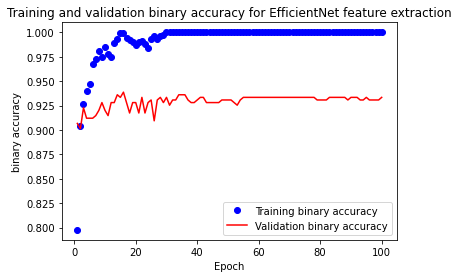

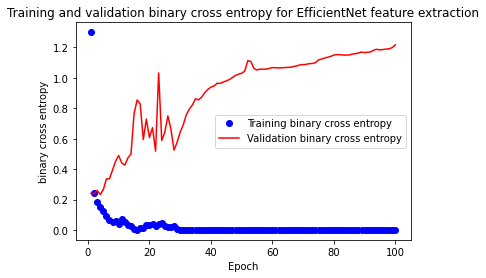

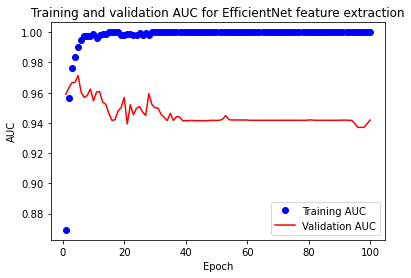

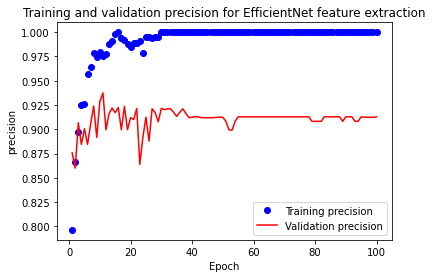

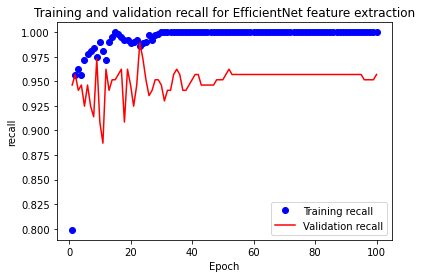

In [27]:
if compileEfficientNetFE:
    metricsKeysNames = zipMetricsKeysWithNames(efficientNetB0FEClassifierHistory.history.keys(), metricNames)
    plotTrainingHistories(efficientNetB0FEClassifierHistory, metricsKeysNames, 'EfficientNet feature extraction')
    plt.show()

### 2.5.3 History plots for finetuned EfficientNet

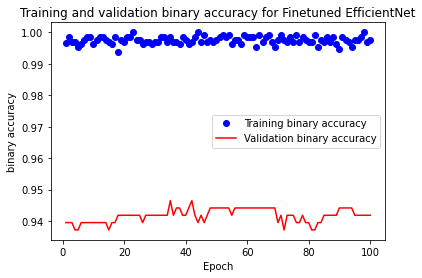

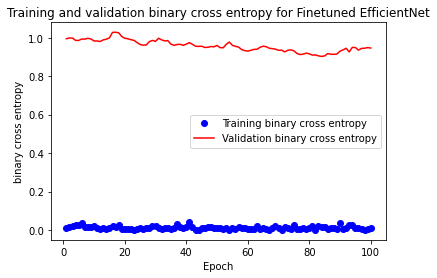

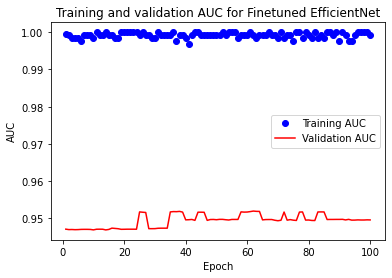

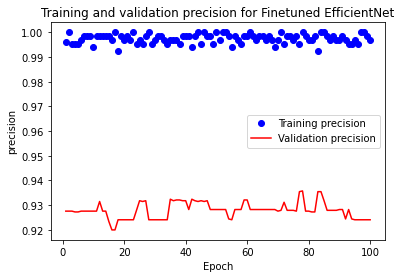

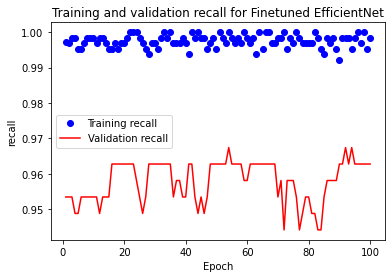

In [28]:
if compileFinetunedEfficientNet:
    metricsKeysNames = zipMetricsKeysWithNames(finetunedEfficientNetB0History.history.keys(), metricNames)
    plotTrainingHistories(finetunedEfficientNetB0History, metricsKeysNames, 'Finetuned EfficientNet')
    plt.show()